In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import keras

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(100)

# Data Preprocessing

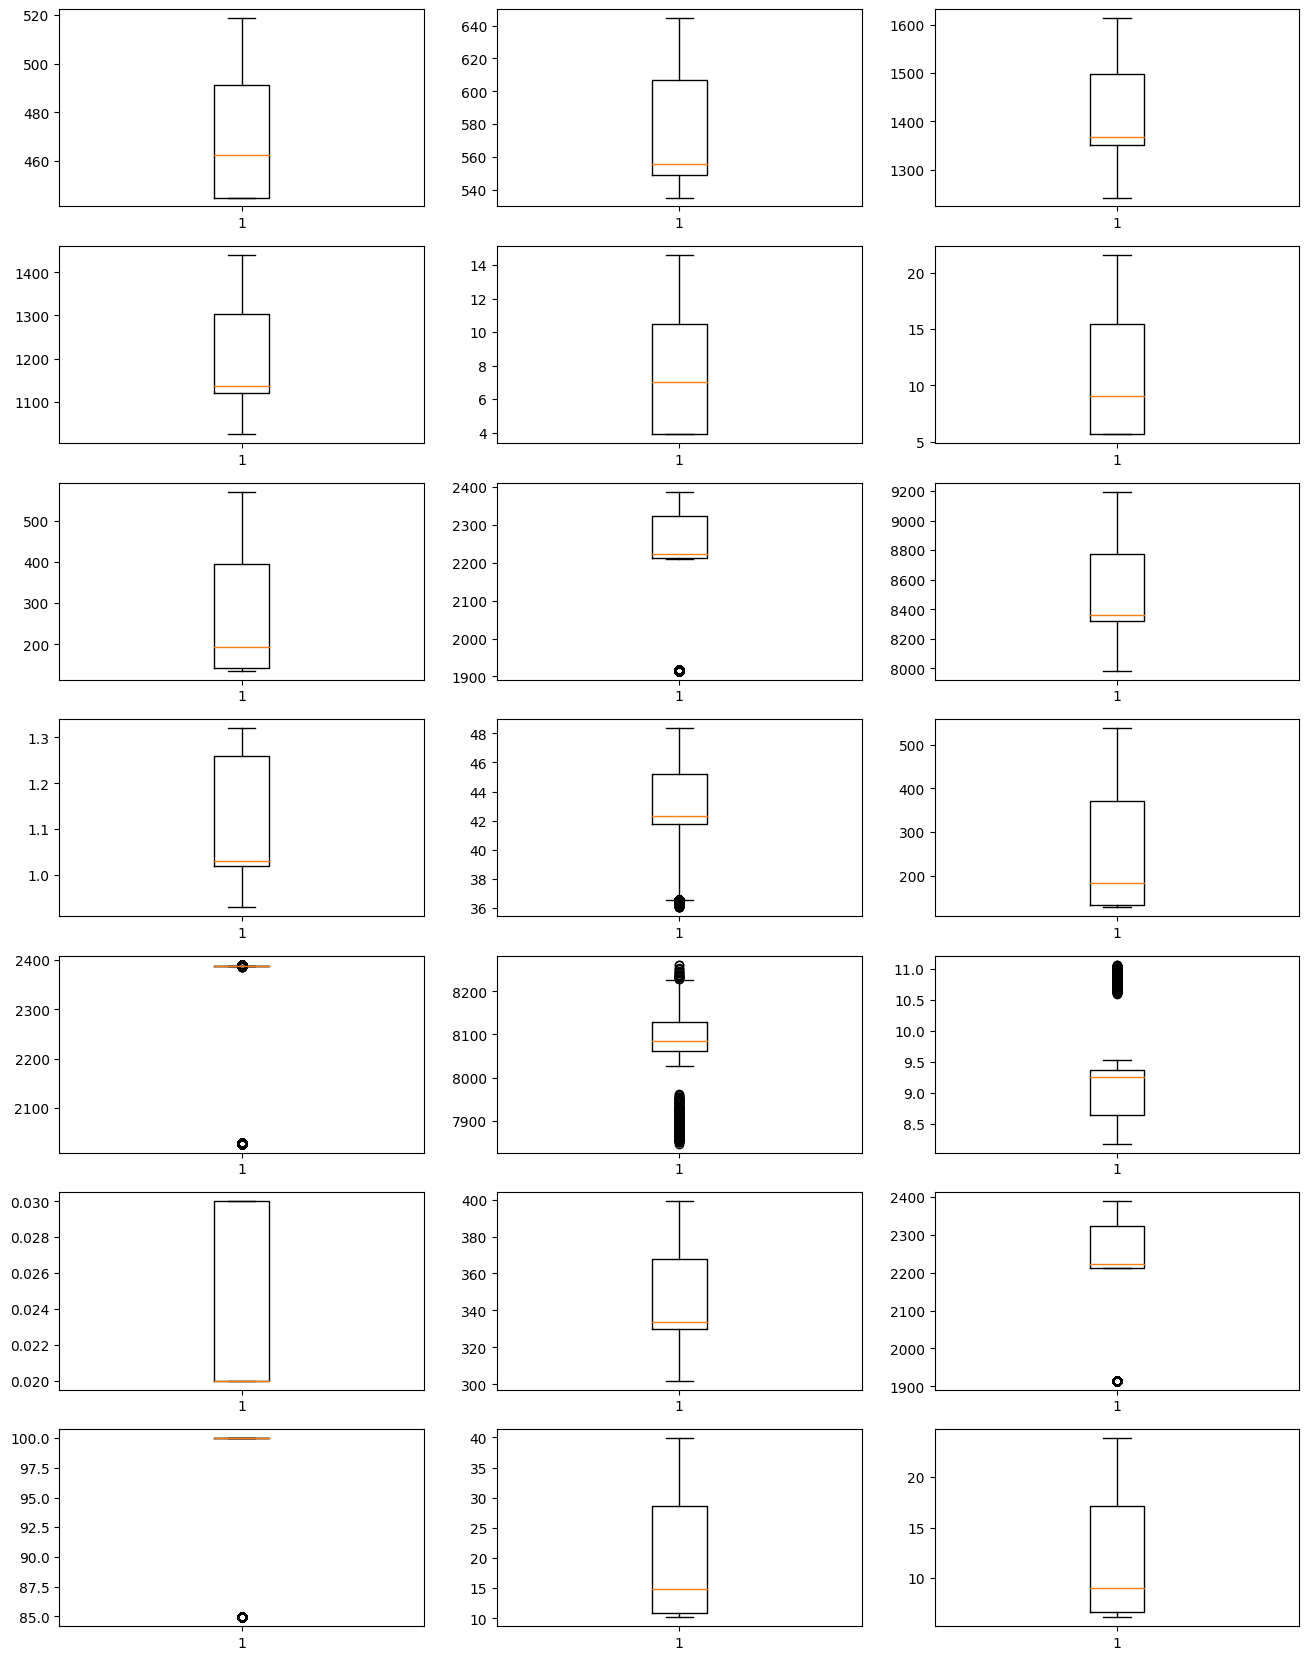

In [2]:
train_data = pd.read_csv("train_FD004.txt", sep= "\s+", header = None)
plt.figure(figsize = (16, 21))
for i in range(21):
    temp_data = train_data.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
plt.show()

In [3]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [4]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [5]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [6]:
test_data = pd.read_csv("test_FD004.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("RUL_FD004.txt", sep = '\s+', header = None)

window_length = 15
shift = 1
early_rul = 130
processed_train_data = []
processed_train_targets = []
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

scaler = MinMaxScaler(feature_range = (-1,1))
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (57763, 15, 14)
Processed training ruls shape:  (57763,)
Processed test data shape:  (1240, 15, 14)
True RUL shape:  (248,)


In [7]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (46210, 15, 14)
Processed validation data shape:  (11553, 15, 14)
Processed train targets shape:  (46210,)
Processed validation targets shape:  (11553,)


# 1D CNN model

In [8]:
def scheduler(epoch):
    if epoch < 50:
        return 0.001
    else:
        return 0.0001

In [9]:
runs = 5

test_rmse = np.zeros(runs)

for i in range(runs):

  model = models.Sequential([
      layers.Conv1D(32, 3, padding = 'same', activation='relu', input_shape = (window_length, processed_train_data.shape[2])),
      layers.MaxPooling1D(2),
      layers.Conv1D(64, 3, padding = 'same', activation='relu'),
      layers.MaxPooling1D(2),
      layers.Conv1D(128, 3, padding = 'same', activation='relu'),
      layers.MaxPooling1D(2),
      layers.Flatten(),
      layers.Dense(window_length*processed_train_data.shape[2], activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=[keras.metrics.RootMeanSquaredError()])

  callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = False)

  history = model.fit(processed_train_data, processed_train_targets, epochs = 150,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 512, verbose = False)

  rul_pred = model.predict(processed_test_data).reshape(-1)
  preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])

  indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
  preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

  RMSE = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))

  test_rmse[i] = RMSE

  print('RMSE in trial', i+1, ':', test_rmse[i])

print(f'Avg test RMSE over 5 iterations : {test_rmse.mean()}')

39/39 [==============================] - 0s 2ms/step
RMSE in trial 1 : 31.783973593838734
39/39 [==============================] - 0s 1ms/step
RMSE in trial 2 : 33.42978324562056
39/39 [==============================] - 0s 1ms/step
RMSE in trial 3 : 33.332227267051444
39/39 [==============================] - 0s 1ms/step
RMSE in trial 4 : 32.942364351046805
39/39 [==============================] - 0s 1ms/step
RMSE in trial 5 : 32.119133512640516
Avg test RMSE over 5 iterations : 32.72149639403962


In [10]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 15, 32)            1376      
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 7, 32)             0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 7, 64)             6208      
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 3, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, 3, 128)            24704     
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 1, 128)           

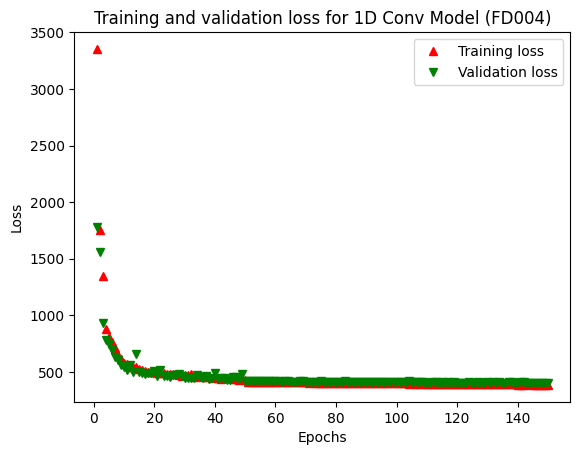

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r^', label='Training loss')
plt.plot(epochs, val_loss, 'gv', label='Validation loss')
plt.title('Training and validation loss for 1D Conv Model (FD004)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [12]:
def compute_s_score(rul_true, rul_pred):
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [13]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  19835.461879198578


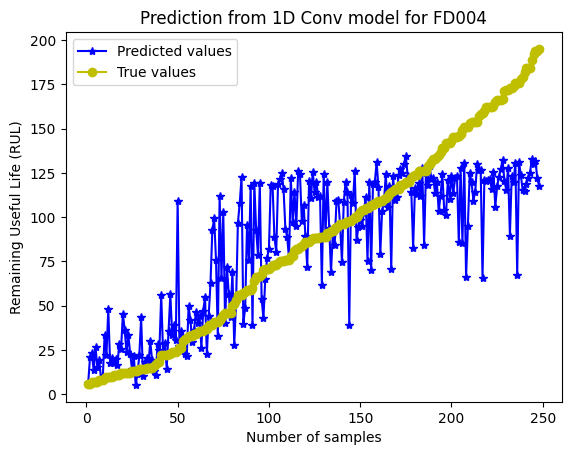

In [14]:
y_pred_series = pd.Series(preds_for_last_example.flatten())
y_test_series = pd.Series(true_rul.flatten())

df = pd.DataFrame({'y_pred_fd004': y_pred_series, 'y_test_fd004': y_test_series})

df = df.sort_values('y_test_fd004')

number_of_sample = range(1, len(true_rul) + 1)

plt.plot(number_of_sample, df['y_pred_fd004'], 'b*-', label='Predicted values')
plt.plot(number_of_sample, df['y_test_fd004'], 'yo-', label='True values')
plt.title('Prediction from 1D Conv model for FD004')
plt.xlabel('Number of samples')
plt.ylabel('Remaining Useful Life (RUL)')
plt.legend()

plt.show()